<a href="https://colab.research.google.com/github/van-dang/MRI-Cloud/blob/master/NeuronSim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About the code

In [0]:
# This demo solves the Bloch-Torrey equation applied to computational diffusion MRI using 
# the finite element method coupled with the theta-method for the spatial discretization.

# The scope of usage: 
# (1) one single domain, (2) pure homogeneous Neumann, 
# (3) Surface/volume diffusion, (4) Arbitrary profiles
# (5) Diffusion tensor/scalar

# Copyright (C) 2017 Van-Dang Nguyen (vdnguyen@kth.se)

# This file is part of DOLFIN.

# DOLFIN is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# DOLFIN is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# GNU Lesser General Public License for more details.

# You should have received a copy of the GNU Lesser General Public License
# along with DOLFIN. If not, see <http://www.gnu.org/licenses/>.

# First added:  2017-10-10
# Last changed: 2019-04-09

# This demo is maintained by Van-Dang Nguyen
# Please report possible problems to vdnguyen@kth.se

# Setting a working environment with FEniCS

In [35]:
from google.colab import files

import platform, sys
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion

if ( LooseVersion(python_version) < LooseVersion("3.0.0")):
    print("Python3 is needed!");
    print("How to fix: Runtime/Change_runtime_type/Python 3");
    sys.exit()
    
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *
    
import matplotlib.pyplot as plt;
from IPython.display import clear_output, display; import time; import dolfin.common.plotting as fenicsplot 
import time

import os, sys, shutil

dolfin_version = dolfin.__version__
print ('dolfin version:', dolfin_version)

!rm -rf * # clean up all files
# Useful commands
# Remove an empty folder      : os.rmdir("my_results")
# Remove a folder with files  : shutil.rmtree("results")
# Make a folder               : os.mkdir("my_results")
# Runtime/Change_runtime_type/Python3

dolfin version: 2018.1.0


# Download the mesh of a realistic neuron

In [36]:
!rm -rf *
spindle_list=['03a_spindle2aFI','03a_spindle6aFI','03b_spindle4aACC','03b_spindle5aACC',
              '03b_spindle6aACC','03b_spindle7aACC','04b_spindle3aFI','05b_spindle5aFI',
              '06b_spindle8aACC','07b_spindle9aACC','08a_spindle13aACC','09o_spindle7aFI',
              '09o_spindle8aFI','10a_spindle18aACC','12a_spindle19aACC','12o_spindle9aFI',
              '13o_spindle10aFI','15o_spindle12aFI','16o_spindle13aFI','19o_spindle14aFI',
              '21o_spindle15aFI','23o_spindle16aFI','25o_spindle17aFI','26o_spindle18aFI',
              '27o_spindle19aFI','28o_spindle20aFI','28o_spindle21aFI','29o_spindle22aFI',
              '30o_spindle23aFI',
];

pyramidal_list=['02a_pyramidal2aFI','02b_pyramidal1aACC','02b_pyramidal1aFI','03a_pyramidal9aFI',
                '03b_pyramidal2aACC','03b_pyramidal3aACC','03b_pyramidal3aFI','03b_pyramidal4aFI',
                '03b_pyramidal9aFI','04a_pyramidal4aACC','04a_pyramidal5aACC','04b_pyramidal5aFI',
                '04b_pyramidal6aACC','04b_pyramidal6aFI','04b_pyramidal7aACC','05a_pyramidal10aACC',
                '05a_pyramidal8aACC','05b_pyramidal7aFI','05b_pyramidal8aFI','05b_pyramidal9aACC',
                '06a_pyramidal11aACC','06b_pyramidal10aFI','06b_pyramidal12aACC','07a_pyramidal13aACC',
                '07b_pyramidal14aACC','08o_pyramidal11aFI','10a_pyramidal15aACC','11a_pyramidal16aACC',
                '11o_pyramidal12aFI','17o_pyramidal13aFI','18o_pyramidal14aFI','20o_pyramidal15aFI',
                '22o_pyramidal16aFI','24o_pyramidal17aFI','25o_pyramidal18aFI','31o_pyramidal19aFI',
];

neuron_id = 1;
neuron_type = 'spindles';

if neuron_type == 'spindles':
    neuron_list = spindle_list;
if neuron_type == 'pyramidals':
    neuron_list = pyramidal_list;
    
neuron_name = neuron_list[neuron_id];
print(neuron_name)

# neuron_dir='https://raw.githubusercontent.com/van-dang/NeuronVolumeMeshes/master/'+neuron_type+'/'+neuron_name+'.msh.zip'

neuron_name='undyAxon_Ax_5E_6_vol'
neuron_dir='https://raw.githubusercontent.com/van-dang/MRI-Cloud/master/comri/meshes/'+neuron_name+'.msh.zip'

!wget -q $neuron_dir
!unzip -q $neuron_name''.msh.zip
!dolfin-convert $neuron_name''.msh $neuron_name''.xml

mesh = Mesh(neuron_name+'.xml');
gdim = mesh.geometry().dim()
print('Mesh size: #vertices: '+str(mesh.num_vertices()) +', #elements: '+str(mesh.num_cells()) );

03a_spindle6aFI
Converting from Gmsh format (.msh, .gmsh) to DOLFIN XML format
Expecting 6369 vertices
Found all vertices
Expecting 30427 cells
Found all cells
Conversion done
Mesh size: #vertices: 6369, #elements: 30427


# Pre-defined functions

In [0]:
def b2g(bvalue, delta, Delta, nperiod, stype):
  gnorm = 0;
  if (stype == 'PGSE'):
      gnorm = sqrt(bvalue)/sqrt(delta*delta*(Delta-delta/3.0));
  if (stype == 'cos_OGSE'):
      gnorm = sqrt(bvalue/(1./8.*delta*delta*delta*(3.-cos(4.*nperiod*pi/delta*Delta))/(nperiod*nperiod)/(pi*pi)));
  return gnorm;

def g2b(gnorm, delta, Delta, nperiod, stype):
  bvalue = 0;
  if (stype == 'PGSE'):
      bvalue = gnorm*gnorm*delta*delta*(Delta-delta/3.0);
  if (stype == 'cos_OGSE'):
      bvalue=gnorm*gnorm*1./8.*delta*delta*delta*(3.-cos(4.*nperiod*pi/delta*Delta))/(nperiod*nperiod)/(pi*pi);
  return bvalue;  

def initial_condition(mesh, R):
  gdim = mesh.geometry().dim()
  if (gdim==2):
    f = Expression("x[0]*x[0]+x[1]*x[1]<eps",eps=R, domain=mesh, degree=2);
  if (gdim==3):
    f = Expression("x[0]*x[0]+x[1]*x[1]+x[2]*x[2]<eps",eps=R, domain=mesh, degree=2);
  return f;

def time_profile(t, delta, Delta, stype):
  ft1, ft2 = 0, 0;
  if stype=='PGSE':
    ft1 = 1.0*(t>=0 and t<delta) 
    ft2 = -1.0*(t>=Delta and t<=Delta+delta);
  if stype=='cos_OGSE':
    ft1 =  cos(2.0*nperiod*pi*t/delta)*(t>=0 and t<delta);
    ft2 = -cos(2.0*nperiod*pi*(t-2.*delta)/delta)*(t>=Delta and t<=Delta+delta);
  return ft1 + ft2;  

def GdotX(g0, g1, g2, mesh):
  gdim = mesh.geometry().dim()
  if (gdim==2):
    GX=Expression("x[0]*g0+x[1]*g1", g0=g0, g1=g1, domain=mesh, degree=3);
  if (gdim==3):
    GX=Expression("x[0]*g0+x[1]*g1+x[2]*g2", g0=g0, g1=g1, g2=g2, domain=mesh, degree=3);
  return GX;

## Theta method
def FuncF(ft, gnorm, GX, ur, ui, vr, vi, K):
    Fr = ft*gnorm*GX*ui*vr - inner(K*grad(ur), grad(vr))
    Fi = - ft*gnorm*GX*ur*vi - inner(K*grad(ui), grad(vi))
    return Fr + Fi

def ThetaMethod_L(ft, gnorm, GX, u1r, u1i, v1r, v1i,k, K, theta):
    L1 = (u1r_0/k*v1r +u1i_0/k*v1i+(1-theta)*FuncF(ft, gnorm, GX, u1r_0, u1i_0, v1r, v1i, K))*dx
    return L1

def ThetaMethod_a(ft, gnorm, GX, u1r, u1i, v1r, v1i,k, K, theta):
    a1 = (u1r/k*v1r   + u1i/k*v1i  -theta*FuncF(ft, gnorm, GX, u1r  , u1i  , v1r, v1i, K))*dx
    return a1

def NoTimeMatrices(u1r, u1i, v1r, v1i, K, GX, theta):
    m1 = (u1r*v1r   + u1i*v1i)*dx
    M = assemble(m1);
    j1 = -GX*(u1i*v1r   - u1r*v1i)*dx
    J = assemble(j1);    
    s1 = inner(K*grad(u1r), grad(v1r))*dx + inner(K*grad(u1i), grad(v1i)) *dx
    S = assemble(s1)
    return M, J, S

def ThetaMethod_A(ft, gnorm, theta, k, M, J, S):
    return 1./k*M + ft*gnorm*theta*J + theta*S
  
def MyFunctionSpaces(mesh, porder):
  dolfin_version = dolfin.__version__
  if dolfin_version=='1.6.0':
    V = FunctionSpace(mesh , "CG", porder); # order 1, 2 components
    W = MixedFunctionSpace([V, V])
  else:
    # For FEniCS 2016, 2017, 2018
    Ve = FiniteElement("CG", mesh.ufl_cell(), porder)
    V = FunctionSpace(mesh,Ve);
    TH = MixedElement([Ve,Ve])
    W = FunctionSpace(mesh, TH)
  return V, W

# Pre-defined parameters

In [0]:
bvalue = 1000;              # bvalue
stype = 'cos_OGSE'; # sequence type
nperiod = 1;
delta, Delta = 5000, 5000 # PGSE sequence
T = Delta+delta;
if (Delta-delta/3.0<=0):
    print('Check time sequence!');
    exit(0);

g0, g1, g2 = 0, 0, 1;       # gradient direction
dcoeff = 3e-3;                   # Diffusion coefficient
if gdim==2:
  K = as_matrix(((dcoeff, 0), (0, dcoeff))) # Diffusion tensor
if gdim==3:
  K = as_matrix(((dcoeff, 0, 0), (0, dcoeff, 0), (0, 0, dcoeff))) # Diffusion tensor
  
nskip = 5;                  # Output frequency (for visualization only)
porder = 1;                 # order of basis functions of FEM
Nsteps = 200;               # number of time intervals

# k = T/Nsteps;
k = 100; # Time-step size

theta = 0.5; # 0.5 - Midpoint method

stepcounter = 0;

# Solve the Bloch-Torrey equation

mesh.hmin:  <bound method PyCapsule.hmin of <dolfin.cpp.mesh.Mesh object at 0x7ff4e8c84d00>> mesh.hmax:  1.545292379305852
t: 0.000000  T: 10000.0 dt: 100.0 gnorm: 5.619852e-04 Completed 0.00%
t: 500.000000  T: 10000.0 dt: 100.0 gnorm: 5.619852e-04 Completed 4.95%
t: 1000.000000  T: 10000.0 dt: 100.0 gnorm: 5.619852e-04 Completed 9.90%
t: 1500.000000  T: 10000.0 dt: 100.0 gnorm: 5.619852e-04 Completed 14.85%
t: 2000.000000  T: 10000.0 dt: 100.0 gnorm: 5.619852e-04 Completed 19.80%
t: 2500.000000  T: 10000.0 dt: 100.0 gnorm: 5.619852e-04 Completed 24.75%
t: 3000.000000  T: 10000.0 dt: 100.0 gnorm: 5.619852e-04 Completed 29.70%
t: 3500.000000  T: 10000.0 dt: 100.0 gnorm: 5.619852e-04 Completed 34.65%
t: 4000.000000  T: 10000.0 dt: 100.0 gnorm: 5.619852e-04 Completed 39.60%
t: 4500.000000  T: 10000.0 dt: 100.0 gnorm: 5.619852e-04 Completed 44.55%
t: 5000.000000  T: 10000.0 dt: 100.0 gnorm: 5.619852e-04 Completed 49.50%
t: 5500.000000  T: 10000.0 dt: 100.0 gnorm: 5.619852e-04 Completed 54.

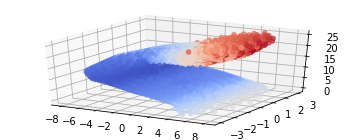

In [39]:
t = 0;
gnorm = b2g(bvalue, delta, Delta, nperiod, stype)

V, W = MyFunctionSpaces(mesh, porder)   
v = TestFunction(W)
v1r, v1i = v[0], v[1]

u = TrialFunction(W);
u1r, u1i = u[0], u[1]

# Initial conditions
Dirac_Delta = initial_condition(mesh, 1e6)
Dirac_Delta = interpolate(Dirac_Delta, V);

import math, sys
checknan = math.isnan(Dirac_Delta.vector().norm('l2'));
if (checknan):
  print("The mesh may be invalid! Please double check");
  sys.exit()

u_0 = Function(W);
assign(u_0.sub(0), Dirac_Delta)
u1r_0, u1i_0 = split(u_0)

GX = GdotX(g0, g1, g2, mesh)   

print('mesh.hmin: ', mesh.hmin,'mesh.hmax: ',mesh.hmax());

M, J, S = NoTimeMatrices(u1r, u1i, v1r, v1i, K, GX, theta);

stepcounter = 0;

ft_prev = time_profile(t, delta, Delta, stype);

solver = KrylovSolver('bicgstab', 'ilu')
solver.parameters["absolute_tolerance"] = 1e-6
solver.parameters["relative_tolerance"] = 1e-4
solver.parameters["maximum_iterations"] = 1000

start_time = time.time()

while t < T + k: # Time-stepping loop
    if stepcounter % nskip == 0:
        print('t: %f '%t, 'T: %.1f'%T, 'dt: %.1f'%k,'gnorm: %e'%gnorm,'Completed %.2f%%'%(float(t)/float(T+k)*100.0));
    ft=time_profile(t, delta, Delta, stype);
    L=ThetaMethod_L(ft_prev, gnorm, GX, u1r, u1i, v1r, v1i,k, K, theta);
    A=ThetaMethod_A(ft, gnorm, theta, k, M, J, S)
    b = assemble(L);
    u = Function(W)
    solver.solve(A,u.vector(),b);
    u1r_0, u1i_0 = split(u)
    ft_prev = ft;
    t += k;
    stepcounter += 1;

elapsed_time = time.time() - start_time


signal = assemble(u1r_0*dx)/assemble(Dirac_Delta*dx);
print('b:',bvalue, 'Signal: %.3e'%signal,', dt: ',k,', hmin: ',mesh.hmin())


print("Elapsed time: %f seconds"%elapsed_time)

u1r_0p = project(u1r_0, V);
u1i_0p = project(u1i_0, V);

File('RealSol.pvd')<<u1r_0p;
File('ImagSol.pvd')<<u1i_0p;

plot(u1r_0p, cmap="coolwarm");